In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
import os

In [7]:
def load_image_data(data_dir, batch_size=32, train_split=0.7, val_split=0.15, test_split=0.15):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    num_classes = len(full_dataset.classes)

    print(f"Número de clases: {num_classes}")
    print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
    print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
    print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

    return trainloader, valloader, testloader, num_classes

from torchvision.models import ResNet50_Weights, ResNet101_Weights

def create_model(num_classes, model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
    else:
        raise ValueError("Model must be 'resnet50' or 'resnet101'")

    for param in list(model.parameters())[:-30]:
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    return model

def train_model(model, trainloader, valloader, epochs=30, lr=0.001, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = valloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                scheduler.step(epoch_loss)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after epoch {epoch+1}')
                    model.load_state_dict(torch.load('best_model.pth'))
                    return model, train_losses, val_losses, train_accuracies, val_accuracies

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f} Acc: {val_accuracies[-1]:.4f}')

    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    return all_labels, all_preds, all_probs, cm, precision, recall, f1

def ensure_cpu(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    return data

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_false_positives_negatives(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(class_names, fp, label='False Positives')
    plt.bar(class_names, fn, bottom=fp, label='False Negatives')
    plt.title('False Positives and Negatives by Class')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(class_names, tp, label='True Positives')
    plt.bar(class_names, tn, bottom=tp, label='True Negatives')
    plt.title('True Positives and Negatives by Class')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [1]:
!unrar x /content/preprocessed_potato_leaf /content/finaldata/

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0205.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0206.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0207.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0208.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0209.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0210.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0211.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0212.jpg      48%  OK 
Extracting 

In [8]:
!ls /content/finaldata/preprocessed_potato_leaf

'Daños por nematodos'	    'Enfermedades fúngicas'  'Tizón tardío (Phytophthora)'
'Daños por plagas'	    'Enfermedades virales'   'Tizón temprano'
'Enfermedades bacterianas'   Salud


In [12]:
# Carga de datos
dataset = "/content/finaldata/preprocessed_potato_leaf"
trainloader, valloader, testloader, num_classes = load_image_data(dataset)



Número de clases: 8
Tamaño del conjunto de entrenamiento: 7279
Tamaño del conjunto de validación: 1560
Tamaño del conjunto de prueba: 1561


In [13]:
# Parte 2: Creación del modelo
model = create_model(num_classes, 'resnet50')

In [14]:
# Parte 3: Entrenamiento del modelo
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, trainloader, valloader)


Using device: cuda
Epoch 1/30
Train Loss: 0.6125 Acc: 0.7982
Val Loss: 0.3694 Acc: 0.8667
Epoch 2/30
Train Loss: 0.3331 Acc: 0.8945
Val Loss: 0.3112 Acc: 0.9038
Epoch 3/30
Train Loss: 0.2404 Acc: 0.9265
Val Loss: 0.2901 Acc: 0.9090
Epoch 4/30
Train Loss: 0.1897 Acc: 0.9457
Val Loss: 0.2681 Acc: 0.9269
Epoch 5/30
Train Loss: 0.1500 Acc: 0.9526
Val Loss: 0.2333 Acc: 0.9250
Epoch 6/30
Train Loss: 0.1363 Acc: 0.9589
Val Loss: 0.2517 Acc: 0.9288
Epoch 7/30
Train Loss: 0.1165 Acc: 0.9672
Val Loss: 0.3438 Acc: 0.9006
Epoch 8/30
Train Loss: 0.0858 Acc: 0.9757
Val Loss: 0.2580 Acc: 0.9314
Epoch 9/30
Train Loss: 0.0886 Acc: 0.9722
Val Loss: 0.2125 Acc: 0.9282
Epoch 10/30
Train Loss: 0.0619 Acc: 0.9837
Val Loss: 0.3085 Acc: 0.9250
Epoch 11/30
Train Loss: 0.0705 Acc: 0.9798
Val Loss: 0.2592 Acc: 0.9288
Epoch 12/30
Train Loss: 0.0724 Acc: 0.9776
Val Loss: 0.3214 Acc: 0.9218
Epoch 13/30
Train Loss: 0.0578 Acc: 0.9815
Val Loss: 0.3248 Acc: 0.9154
Early stopping triggered after epoch 14


<ipython-input-7-0c73da5903e6>:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [15]:
# Parte 4: Evaluación del modelo
all_labels, all_preds, all_probs, cm, precision, recall, f1 = evaluate_model(model, testloader)

Test Precision: 0.9340
Test Recall: 0.9340
Test F1-score: 0.9332


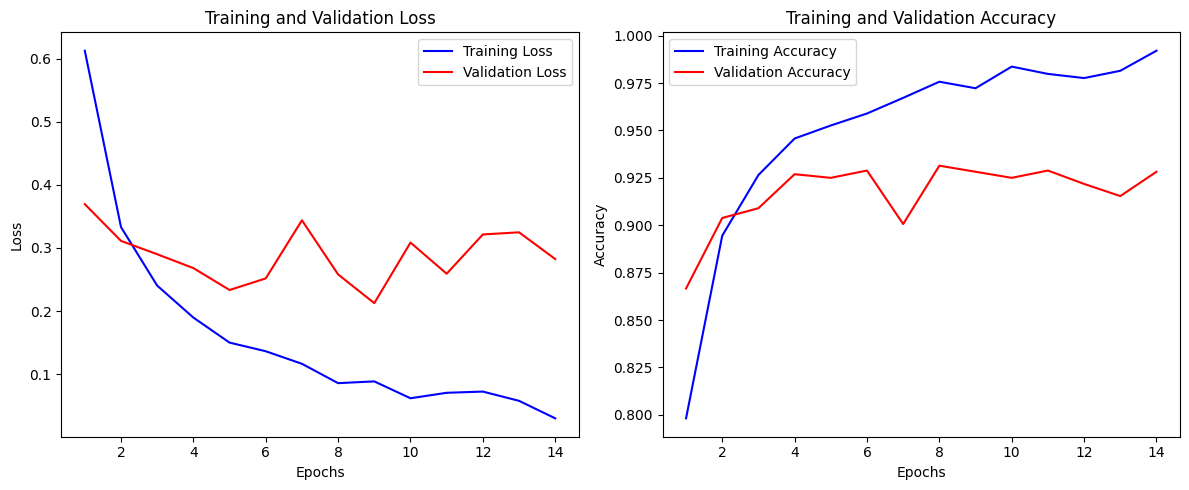

In [16]:
# Parte 5: Visualización de resultados
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

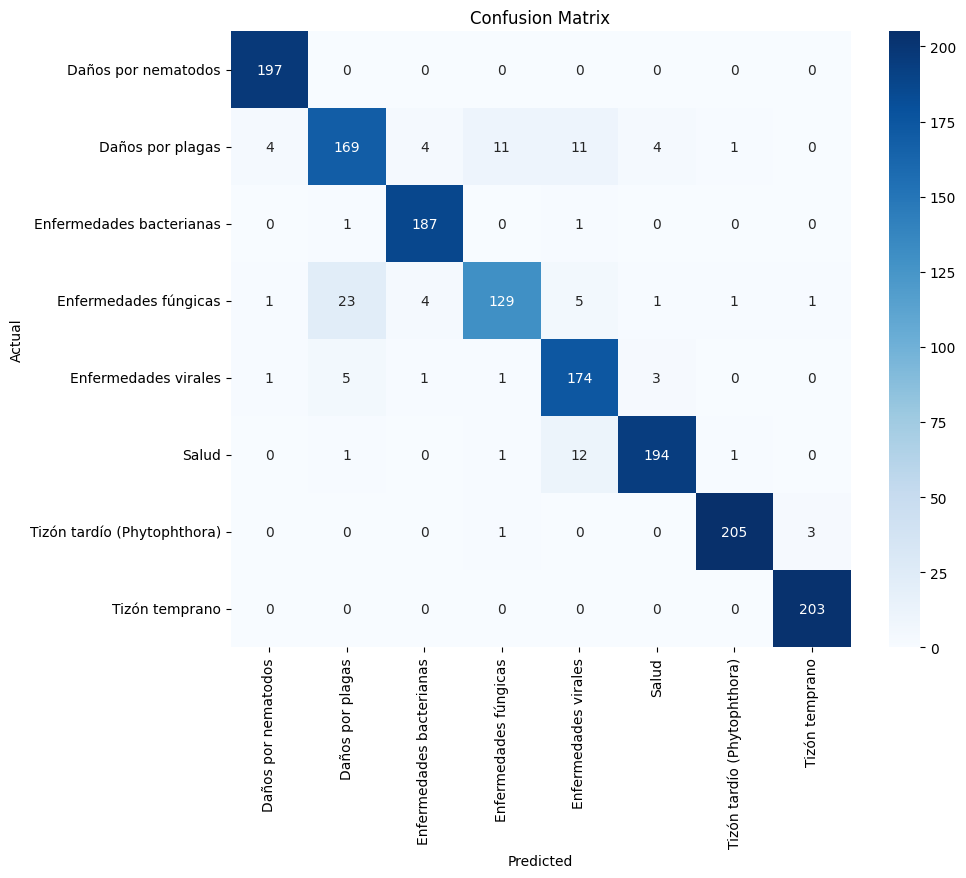

In [24]:
# Access classes from the original Dataset used to create the trainloader
plot_confusion_matrix(ensure_cpu(cm), trainloader.dataset.dataset.classes)


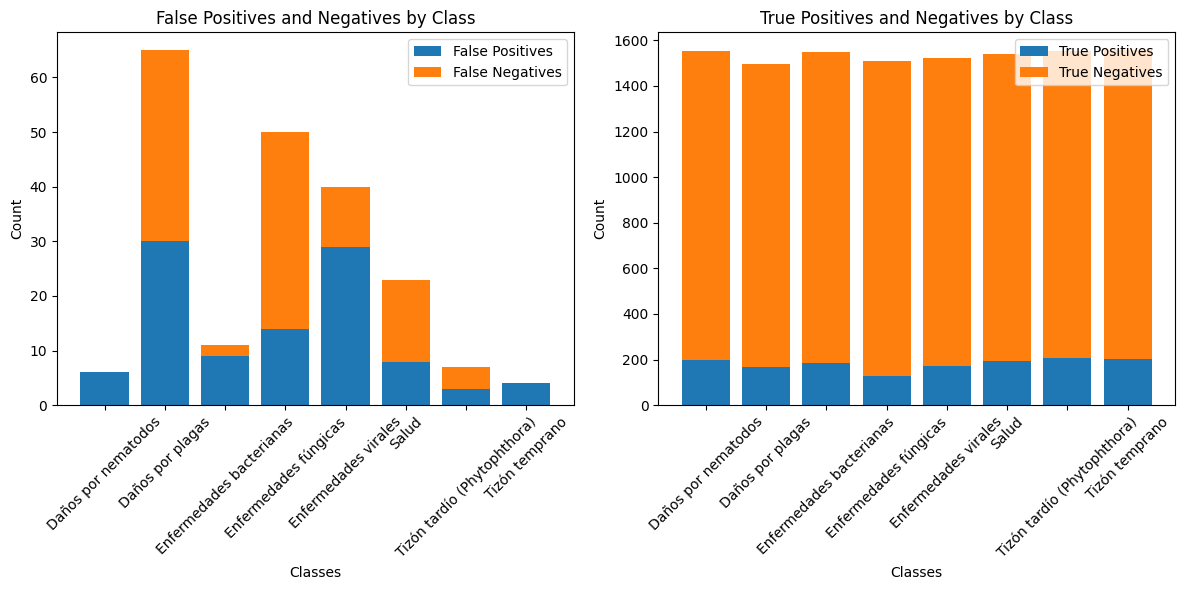

In [25]:
plot_false_positives_negatives(
    ensure_cpu(all_labels),
    ensure_cpu(all_preds),
    trainloader.dataset.dataset.classes # Access classes from the original Dataset
)

In [21]:
# Guardar el modelo completo
torch.save(model, 'modelo_entrenado_TL_R50.pth')

# Guardar solo los parámetros del modelo
torch.save(model.state_dict(), 'modelo_entrenado_TL_R50_parameters.pth')

print("Modelo guardado exitosamente como 'modelo_entrenado_TL_R50.pth'")


Modelo guardado exitosamente como 'modelo_entrenado_TL_R50.pth'


In [22]:
from google.colab import files

# Descargar el archivo del modelo completo
files.download('modelo_entrenado_TL_R50.pth')

# Descargar el archivo de los parámetros
files.download('modelo_entrenado_TL_R50_parameters.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# ResNet101
model = create_model(num_classes, 'resnet101')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 187MB/s]


In [26]:
# Parte 3: Entrenamiento del modelo
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, trainloader, valloader)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/30
Train Loss: 0.6056 Acc: 0.7979
Val Loss: 0.3196 Acc: 0.8923
Epoch 2/30
Train Loss: 0.3153 Acc: 0.9012
Val Loss: 0.2484 Acc: 0.9122
Epoch 3/30
Train Loss: 0.2003 Acc: 0.9356
Val Loss: 0.2429 Acc: 0.9218
Epoch 4/30
Train Loss: 0.1727 Acc: 0.9455
Val Loss: 0.2817 Acc: 0.9141
Epoch 5/30
Train Loss: 0.1295 Acc: 0.9575
Val Loss: 0.2230 Acc: 0.9353
Epoch 6/30
Train Loss: 0.1016 Acc: 0.9729
Val Loss: 0.2126 Acc: 0.9353
Epoch 7/30
Train Loss: 0.0812 Acc: 0.9762
Val Loss: 0.2429 Acc: 0.9308
Epoch 8/30
Train Loss: 0.0816 Acc: 0.9762
Val Loss: 0.2664 Acc: 0.9321
Epoch 9/30
Train Loss: 0.0703 Acc: 0.9783
Val Loss: 0.3353 Acc: 0.9224
Epoch 10/30
Train Loss: 0.0719 Acc: 0.9766
Val Loss: 0.2708 Acc: 0.9308
Epoch 11/30
Train Loss: 0.0341 Acc: 0.9902
Val Loss: 0.2071 Acc: 0.9436
Epoch 12/30
Train Loss: 0.0171 Acc: 0.9957
Val Loss: 0.2161 Acc: 0.9455
Epoch 13/30
Train Loss: 0.0139 Acc: 0.9963
Val Loss: 0.2037 Acc: 0.9500
Epoch 14/30
Train Loss: 0.0111 Acc: 0.9971
Val Loss: 0.1968 Acc: 0.9513
E

<ipython-input-7-0c73da5903e6>:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [27]:
# Parte 4: Evaluación del modelo
all_labels, all_preds, all_probs, cm, precision, recall, f1 = evaluate_model(model, testloader)

Test Precision: 0.9562
Test Recall: 0.9564
Test F1-score: 0.9560


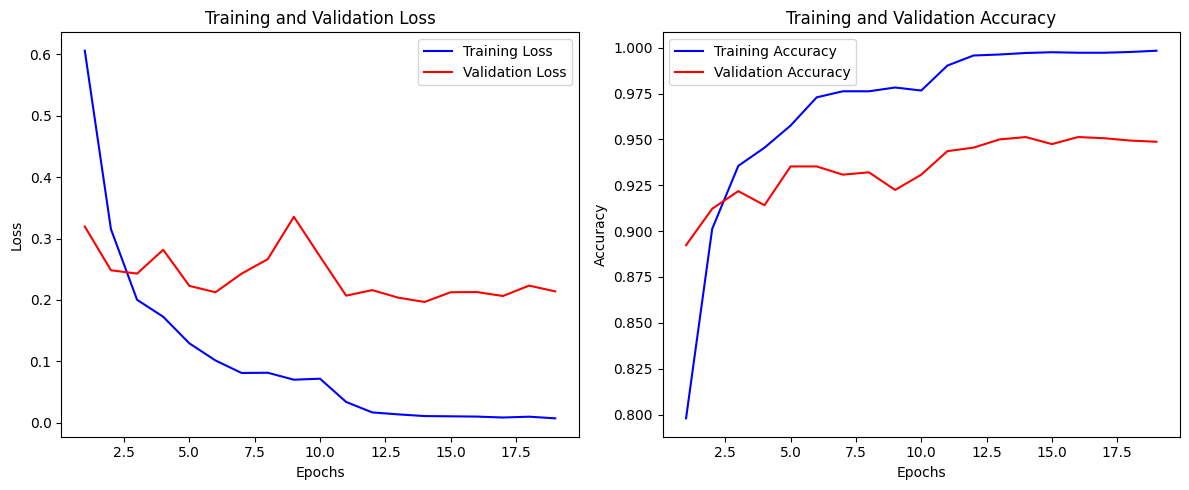

In [28]:
# Parte 5: Visualización de resultados
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

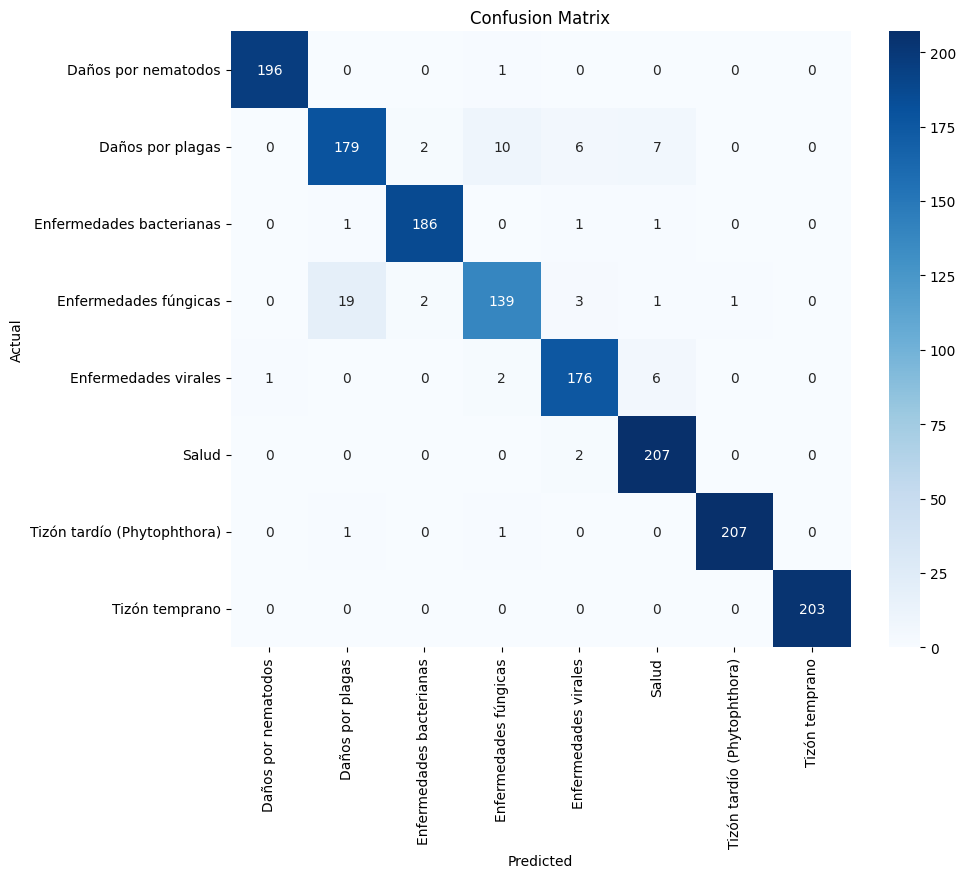

In [29]:
# Access classes from the original Dataset used to create the trainloader
plot_confusion_matrix(ensure_cpu(cm), trainloader.dataset.dataset.classes)

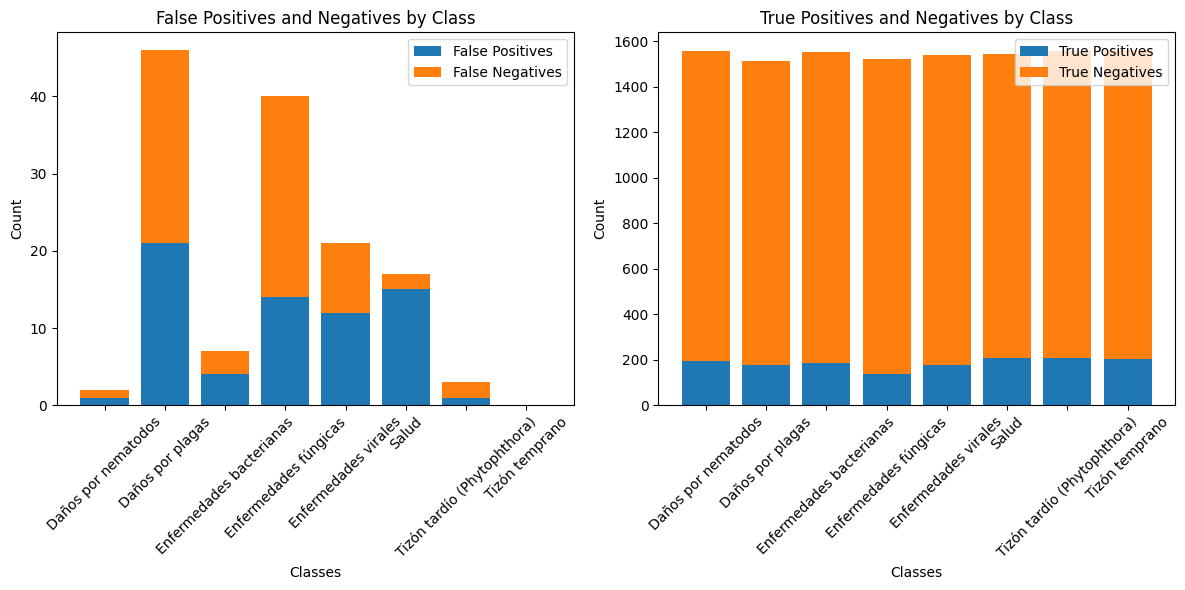

In [30]:
plot_false_positives_negatives(
    ensure_cpu(all_labels),
    ensure_cpu(all_preds),
    trainloader.dataset.dataset.classes # Access classes from the original Dataset
)

In [31]:
# Guardar el modelo completo
torch.save(model, 'modelo_entrenado_resnet101.pth')

# Guardar solo los parámetros del modelo
torch.save(model.state_dict(), 'modelo_entrenado_resnet101_parameters.pth')

print("Modelo guardado exitosamente como 'modelo_entrenado_resnet101.pth'")

Modelo guardado exitosamente como 'modelo_entrenado_resnet101.pth'


In [32]:
from google.colab import files

# Descargar el archivo del modelo completo
files.download('modelo_entrenado_resnet101.pth')

# Descargar el archivo de los parámetros
files.download('modelo_entrenado_resnet101_parameters.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>